# The Quantum Random Number Generator

In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit import QuantumCircuit, execute, Aer
from qiskit.tools.jupyter import *
import matplotlib.pyplot as plt
import numpy as np
from math import pi
%matplotlib inline

# The Mapping Function
We define a function which takes the output of our quantum circuit and maps it into a specified range, as provided by the user.

In [2]:
def real_map(value, leftMin, leftMax, rightMin, rightMax):
    # Maps one range to another
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

# The basic Quantum Random Number generator
Now we define a very basic quantum random number generator, and the process of random number generation can be explained as:  

* Create a quantum circuit with (at least three) a few qubits, add the classical registers.  


* Add a hadamard gate on each of the qubits, making the final state an equal superposition of all the available states.  


* Do a measurement with 'statevector_simulator' and find the final state of the circuit.  


* We can have $2^n$ unique states and the final result will be a random number out of those states.

In [8]:
# Quantum Random Number generator
def QRandom(a, b, qubits):
    q = QuantumRegister(qubits, 'q')
    circ = QuantumCircuit(q)
    c0 = ClassicalRegister(2, 'c0')
    circ.add_register(c0)

    for i in range(qubits):
        circ.h(q[i])

    for i in range(qubits):
        circ.measure(q[i], c0)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    output = result.get_statevector(circ, decimals=5)

    n1 = 0
    n2 = 0
    n3 = 0
    for i in range( output.size ):
        if abs(output[i]) != 0:
            n1 = i
            n2 = np.real(output[i])
            n3 = np.imag(output[i])
    
    y = real_map(n1+n2+n3, -qubits, len(output)-1+qubits, a, b) 
    return y

# Generating random numbers with our Quantum RNG

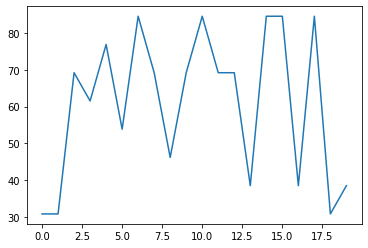

In [11]:
y = []
for i in range(20):
    y.append(QRandom(0,100,3))
    
plt.plot(y)